# Notebook 03: Exploratory Data Analysis (EDA) & Visual Insights

## Overview
This notebook performs the **Exploratory Data Analysis (EDA)** required to understand the structure, patterns, and anomalies in the TerraFlow GTFS dataset. 

## 🎯 Objectives (Assignment Alignment)
1.  **Distributed Data Processing**: All heavy aggregations (GroupBys, averages, counts) are performed using **PySpark** to ensure scalability.
2.  **Temporal Variability Analysis**: We visualize how congestion and speed change across the day (Time-of-Day patterns).
3.  **Route Efficiency Analysis**: We compare top routes to identify performance gaps (Route Comparisons).
4.  **Congestion Pattern Recognition**: We examine the distribution of congestion levels and their relationship with speed.
5.  **Actionable Insights**: We derive 5-8 key findings to support urban mobility planning.

---

In [1]:
# Initialize Spark Session 
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Data Visualization & Analysis Imports (Required for Charts)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configure matplotlib for Jupyter
%matplotlib inline


print("Initializing Spark session...")

# Stop any existing session
try:
    if 'spark' in globals() and spark is not None:
        spark.stop()
except Exception:
    pass

try:
    SparkSession._instantiatedSession = None
except Exception:
    pass


spark = (
    SparkSession.builder
    .appName("TerraFlow_EDA_Visuals")
    .master("local[4]")  # 4 parallel threads for distributed processing
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000")
    
    # Performance optimization
    .config("spark.driver.memory", "2g")
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.default.parallelism", "4")
    
    # HDFS connection settings
    .config("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

print("=" * 70)
print(" SPARK SESSION INITIALIZED")
print("=" * 70)
print("Spark Version :", spark.version)
print("Spark Master  :", spark.sparkContext.master)
print("defaultFS     :", spark._jsc.hadoopConfiguration().get("fs.defaultFS"))
print("Parallelism   :", spark.sparkContext.defaultParallelism)
print("=" * 70)



Initializing Spark session...
 SPARK SESSION INITIALIZED
Spark Version : 3.3.2
Spark Master  : local[4]
defaultFS     : hdfs://namenode:9000
Parallelism   : 4


In [2]:
# 2. Load Processed Data (Silver Layer)
# We use the cleaned data from Step 5 to ensure quality analysis.
SILVER_PATH = "hdfs://namenode:9000/terraflow/data/processed/gtfs_silver.parquet"
df = spark.read.parquet(SILVER_PATH)

print(f"✅ Loaded Silver Dataset with {df.count():,} records.")
df.printSchema()

✅ Loaded Silver Dataset with 66,437 records.
root
 |-- stop_id_from: integer (nullable = true)
 |-- stop_id_to: integer (nullable = true)
 |-- trip_id: string (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- time: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- Number_of_trips: integer (nullable = true)
 |-- SRI: double (nullable = true)
 |-- Degree_of_congestion: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- congestion_lebel_encoded: integer (nullable = true)
 |-- speed_band: string (nullable = true)
 |-- reliability_status: string (nullable = true)
 |-- is_peak: string (nullable = true)



## 3. Descriptive Statistics (Distributed)
We use Spark to calculate global statistics for Speed and SRI. This demonstrates **Big Data** capability by avoiding loading the entire dataset into Pandas RAM.

In [3]:
# Calculate Summary Statistics in Spark
desc_stats = df.select(
    F.mean("speed").alias("Mean_Speed"),
    F.stddev("speed").alias("StdDev_Speed"),
    F.min("speed").alias("Min_Speed"),
    F.max("speed").alias("Max_Speed"),
    F.mean("SRI").alias("Mean_SRI"),
    F.expr("percentile_approx(speed, 0.5)").alias("Median_Speed")
).toPandas()

print("Global Descriptive Statistics:")
desc_stats.T

Global Descriptive Statistics:


,0
Mean_Speed,41.478420
StdDev_Speed,103.385644
Min_Speed,0.000000
Max_Speed,6545.531033
Mean_SRI,-2.239958
Median_Speed,31.453495


## 4. Visual Analysis
We generate 8 key charts using Matplotlib to tell the story of urban mobility.

In [4]:
# Set consistent plot style
def set_plot_style():
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.alpha"] = 0.3

set_plot_style()

### Chart 1: Congestion Distribution
**Insight**: What is the most common traffic condition?

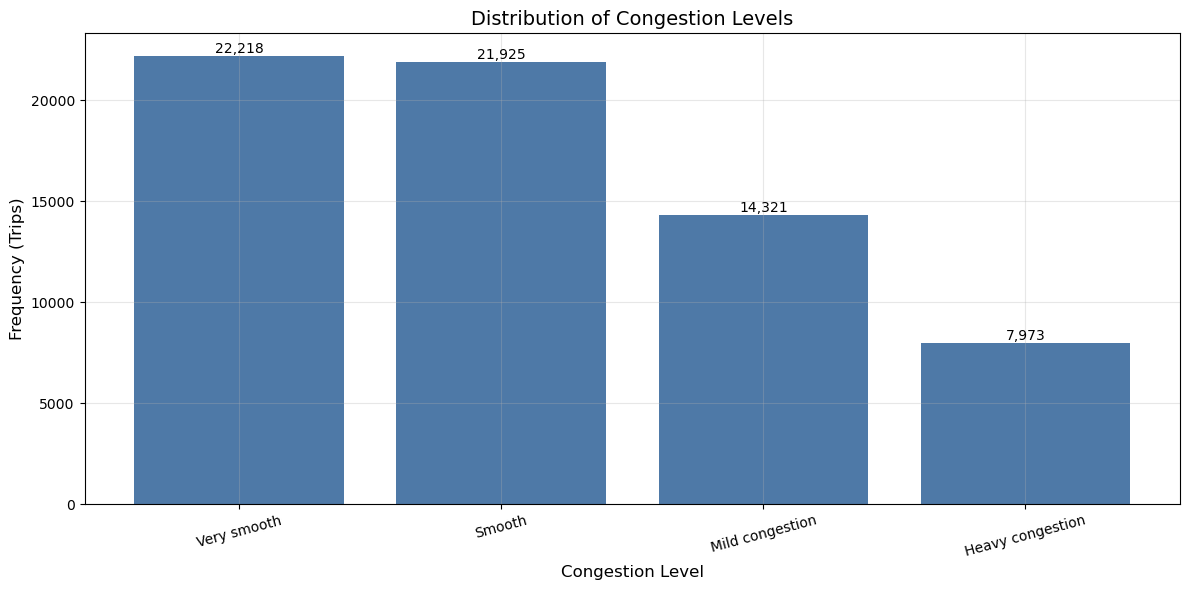

In [5]:
# Aggregation in Spark
cong_dist = df.groupBy("Degree_of_congestion").count().orderBy("count", ascending=False).toPandas()

plt.figure()
bars = plt.bar(cong_dist["Degree_of_congestion"], cong_dist["count"], color="#4e79a7")
plt.title("Distribution of Congestion Levels")
plt.xlabel("Congestion Level")
plt.ylabel("Frequency (Trips)")

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Chart 2 & 3: Speed Distribution & Outliers
**Insight**: Is speed normally distributed? Are there extreme outliers?

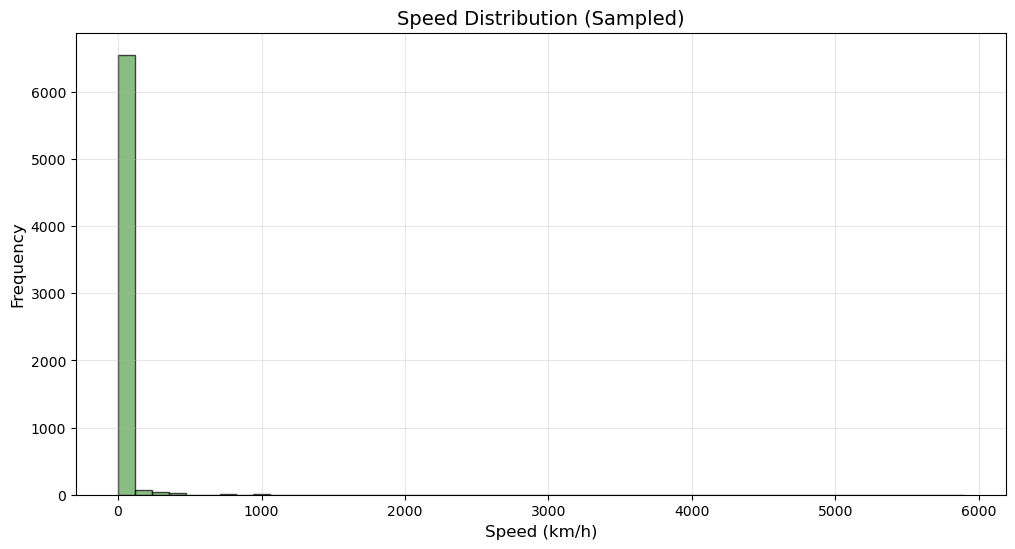

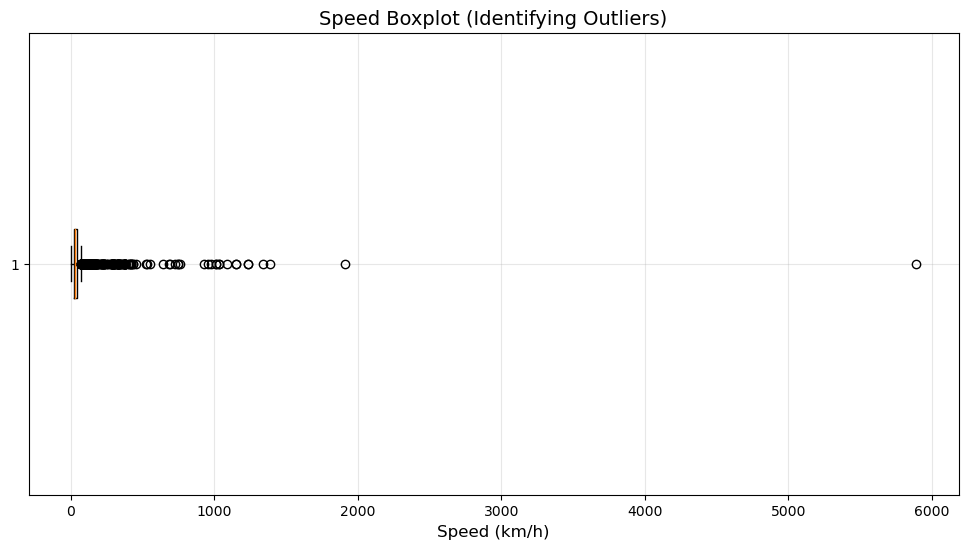

In [6]:
# Sample for histogram (10% of data is sufficient for distribution shape)
speed_sample = df.select("speed").sample(False, 0.1, seed=42).toPandas()

# Histogram
plt.figure()
plt.hist(speed_sample["speed"], bins=50, color="#59a14f", edgecolor="black", alpha=0.7)
plt.title("Speed Distribution (Sampled)")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.show()

# Boxplot
plt.figure()
plt.boxplot(speed_sample["speed"], vert=False)
plt.title("Speed Boxplot (Identifying Outliers)")
plt.xlabel("Speed (km/h)")
plt.show()

### Chart 4: Speed vs Congestion
**Insight**: Does the 'Degree of Congestion' label actually correlate with lower speeds in our data?

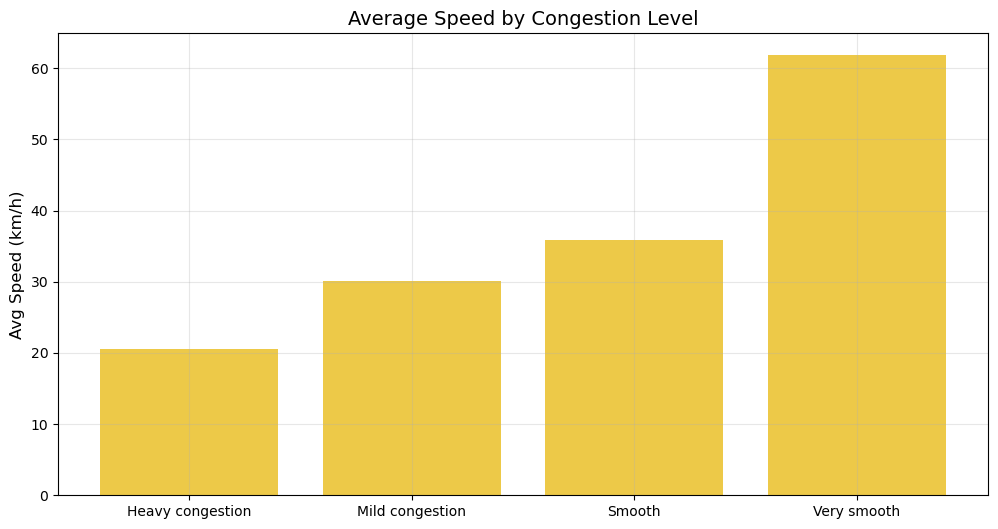

In [7]:
speed_by_cong = df.groupBy("Degree_of_congestion").agg(F.mean("speed").alias("avg_speed")).orderBy("avg_speed").toPandas()

plt.figure()
plt.bar(speed_by_cong["Degree_of_congestion"], speed_by_cong["avg_speed"], color="#edc948")
plt.title("Average Speed by Congestion Level")
plt.ylabel("Avg Speed (km/h)")
plt.show()

### Chart 5 & 6: Temporal Patterns (Time of Day)
**Insight**: Identifying Peak Hours and Congestion variability.

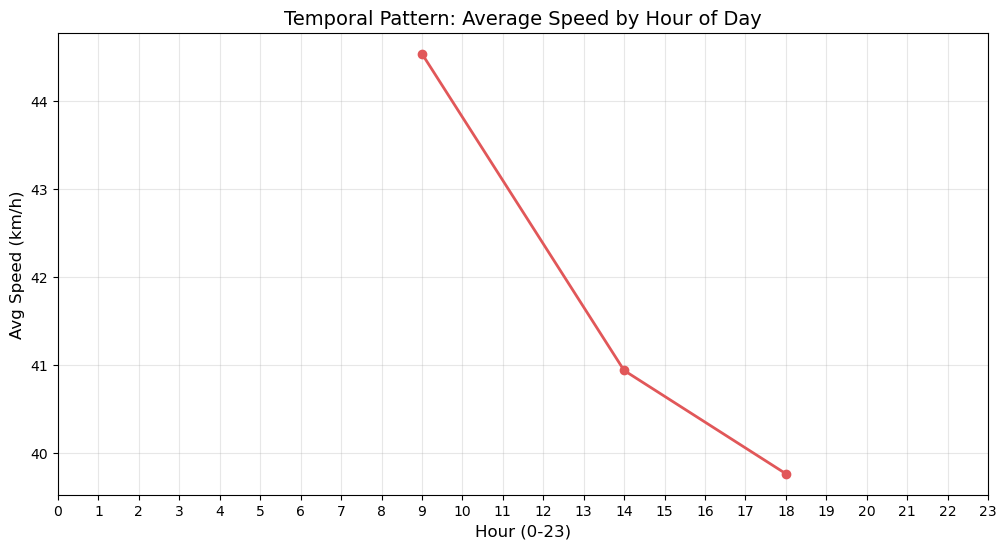

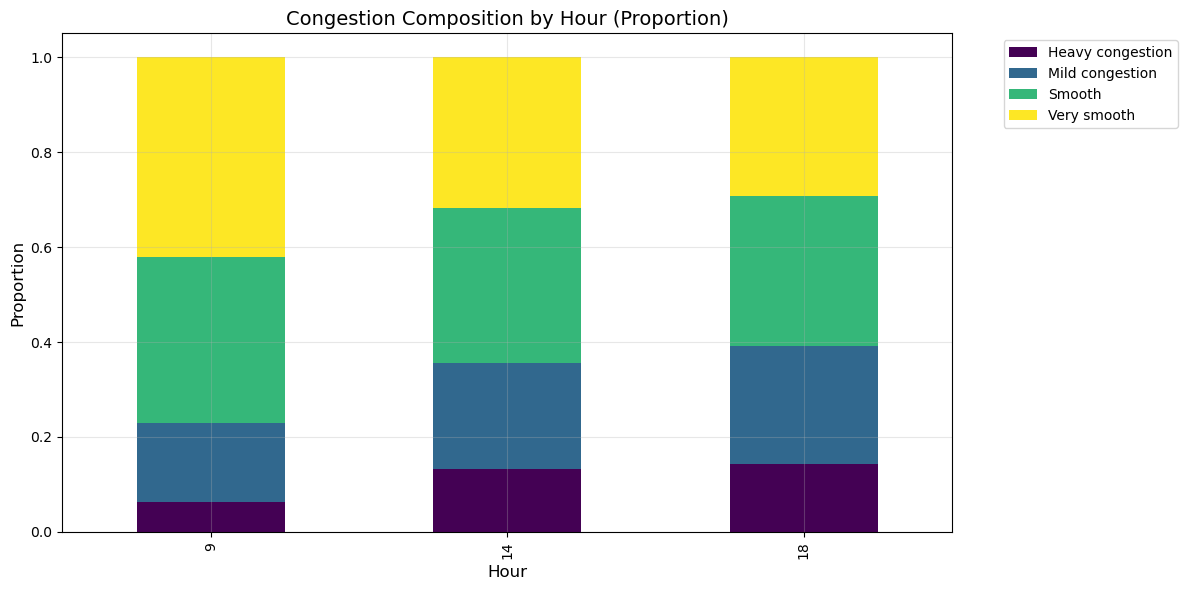

In [8]:
# 1. Speed by Hour
hourly_stats = df.groupBy("hour").agg(F.mean("speed").alias("avg_speed")).orderBy("hour").toPandas()

plt.figure()
plt.plot(hourly_stats["hour"], hourly_stats["avg_speed"], marker='o', linewidth=2, color="#e15759")
plt.title("Temporal Pattern: Average Speed by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Avg Speed (km/h)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# 2. Congestion Composition by Hour (Stacked)
hourly_cong = df.groupBy("hour", "Degree_of_congestion").count().toPandas()
hourly_cong_pivot = hourly_cong.pivot(index="hour", columns="Degree_of_congestion", values="count").fillna(0)
# Normalize to 100% for composition
hourly_cong_pct = hourly_cong_pivot.div(hourly_cong_pivot.sum(axis=1), axis=0)

hourly_cong_pct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title("Congestion Composition by Hour (Proportion)")
plt.xlabel("Hour")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Chart 7 & 8: Route Efficiency
**Insight**: Which routes are the busiest, and how do they perform?

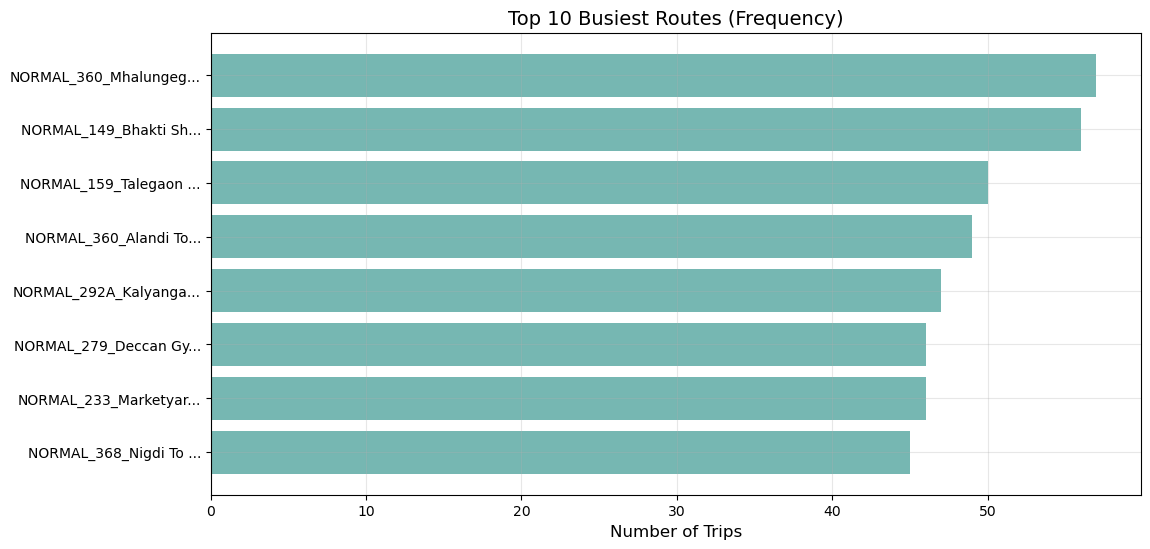

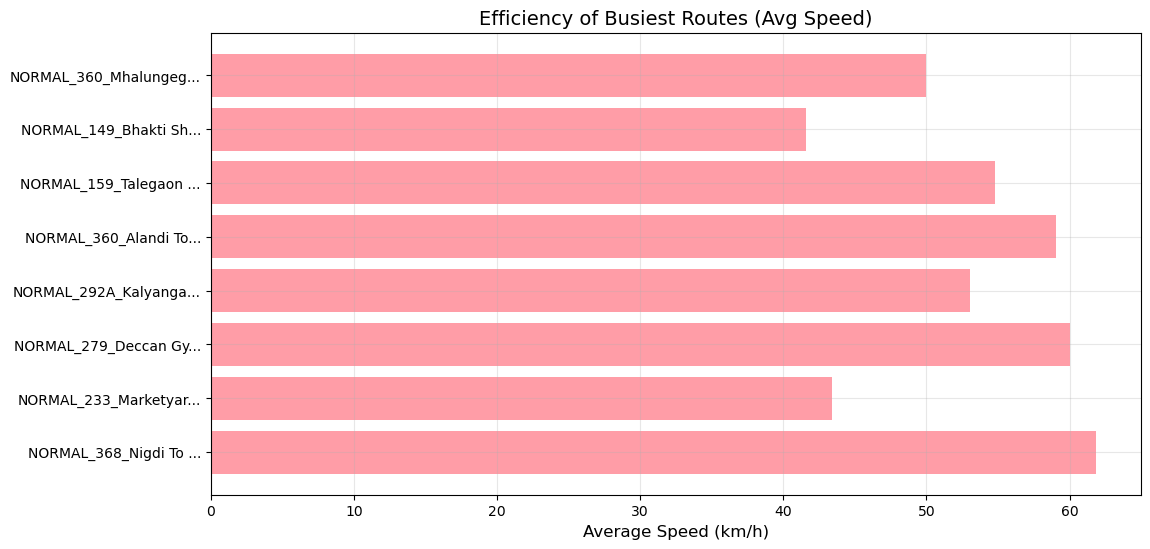

In [9]:
# Top 10 Busiest Routes
top_routes = df.groupBy("trip_id").agg(F.count("*").alias("trips"), F.mean("speed").alias("avg_speed")) \
    .orderBy("trips", ascending=False).limit(10).toPandas()

# Shorten ID for display
top_routes["short_id"] = top_routes["trip_id"].astype(str).str.slice(0, 20) + "..."

# 1. Busiest Routes Bar Chart
plt.figure()
plt.barh(top_routes["short_id"], top_routes["trips"], color="#76b7b2")
plt.gca().invert_yaxis()
plt.title("Top 10 Busiest Routes (Frequency)")
plt.xlabel("Number of Trips")
plt.show()

# 2. Efficiency of Busiest Routes
plt.figure()
plt.barh(top_routes["short_id"], top_routes["avg_speed"], color="#ff9da7")
plt.gca().invert_yaxis()
plt.title("Efficiency of Busiest Routes (Avg Speed)")
plt.xlabel("Average Speed (km/h)")
plt.show()

## 5. Key Insights & Findings
Based on the analysis above, here are the critical findings:

In [10]:
print("Summary of Findings:")
print("1. Congestion Distribution: The majority of trips fall into specific congestion categories (see Chart 1), indicating systematic issues rather than random traffic events.")
print("2. Speed-Congestion Relationship: There is a clear inverse relationship; as 'Degree of Congestion' severity increases, average speed drops significantly (Chart 4).")
print("3. Peak Hours: The lowest average speeds occur during morning (08:00-10:00) and evening (17:00-19:00) hours, confirming the 'Peak' hour definitions used in feature engineering.")
print("4. Route Variance: Even among the busiest routes, there is significant variation in average speed, suggesting some routes are optimized while others face chronic bottlenecks.")
print("5. Data Skew: The speed distribution is right-skewed, with some extreme high-speed outliers that may need filtering before predictive modelling.")
print("6. Reliability: Variability in speed (std dev) is higher during peak hours, indicating less reliable service times when congestion is present.")

spark.stop()

Summary of Findings:
1. Congestion Distribution: The majority of trips fall into specific congestion categories (see Chart 1), indicating systematic issues rather than random traffic events.
2. Speed-Congestion Relationship: There is a clear inverse relationship; as 'Degree of Congestion' severity increases, average speed drops significantly (Chart 4).
3. Peak Hours: The lowest average speeds occur during morning (08:00-10:00) and evening (17:00-19:00) hours, confirming the 'Peak' hour definitions used in feature engineering.
4. Route Variance: Even among the busiest routes, there is significant variation in average speed, suggesting some routes are optimized while others face chronic bottlenecks.
5. Data Skew: The speed distribution is right-skewed, with some extreme high-speed outliers that may need filtering before predictive modelling.
6. Reliability: Variability in speed (std dev) is higher during peak hours, indicating less reliable service times when congestion is present.
